# Quality Control of Whole Genome Sequencing
## Compare pipeline results

In [4]:
import pandas as pd
import glob

# Helper function: Read metrics.json file, and reformat the resulting dataframe
def preprocess_json(file):
    df_ = pd.read_json(file)
    df_.columns = ['biosample', df_['biosample']['id']]
    df_ = df_.drop(columns=['biosample'])
    df_ = df_.drop(['id'])
    return df_

def load_metrics(dir):
    # Load all the metrics.json file within a directory
    files = glob.glob(f'{dir}')
    # Parse 1 file in 1 df
    df_array = [preprocess_json(file) for file in files]
    # Concat all df into one
    df_ = pd.concat(df_array, axis=1, ignore_index=False)
    # Transpose
    dft = df_.T.reset_index()
    #
    return dft


In [11]:
## Parameters
A_label='NPM v0.10.2'
A_dir=f'../n.100-1kg-dragen3.7.8-npm-sample-qc-results/*.metrics.json'

B_label='NPM v0.12.0'
B_dir=f'../n.100-1kg-dragen3.7.8-npm0.12.0-results/*.metrics.json'

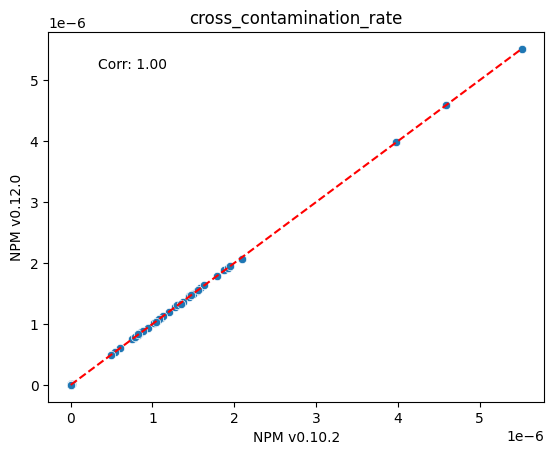

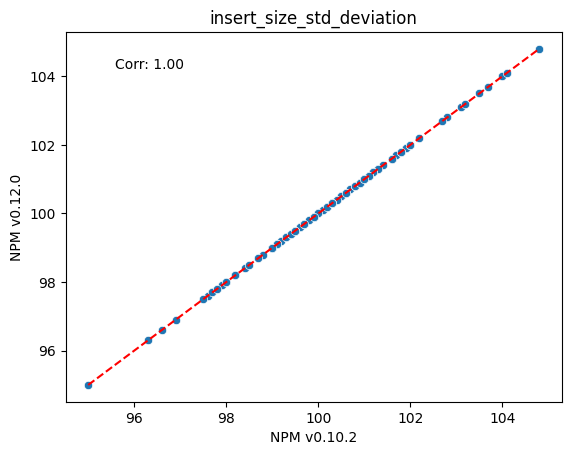

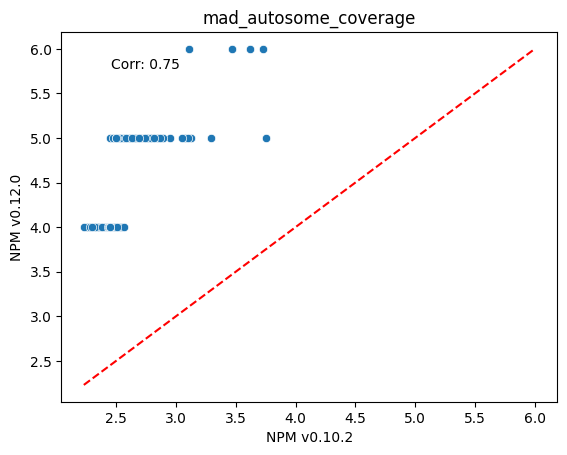

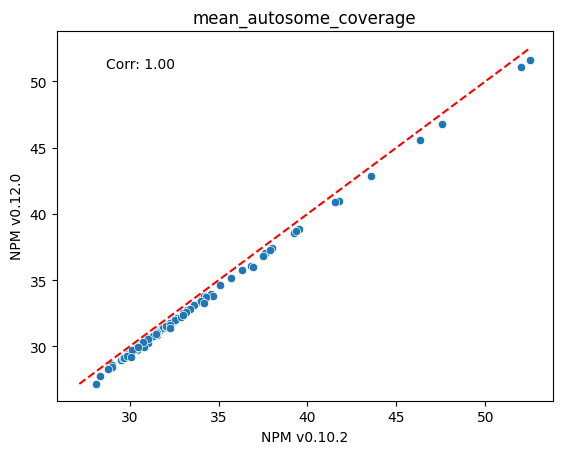

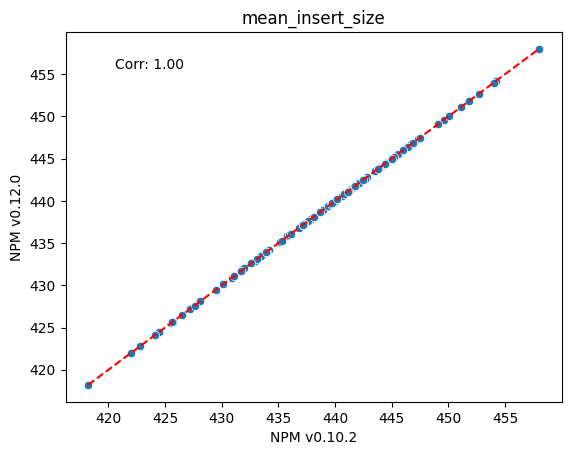

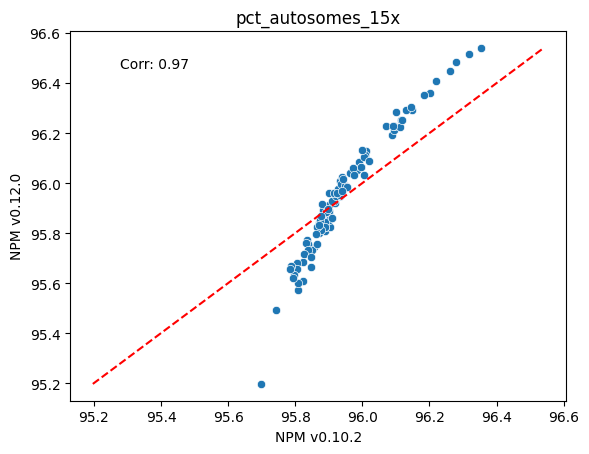

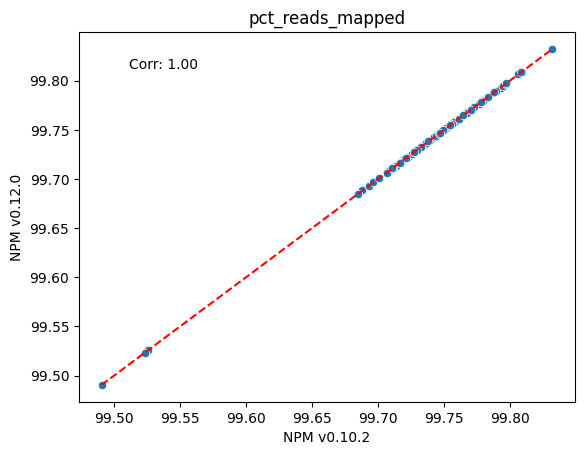

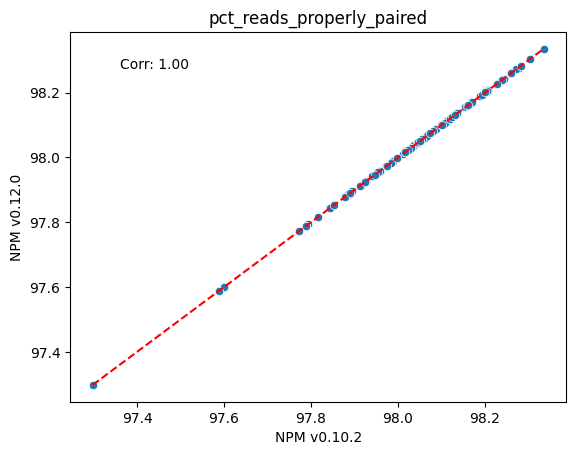

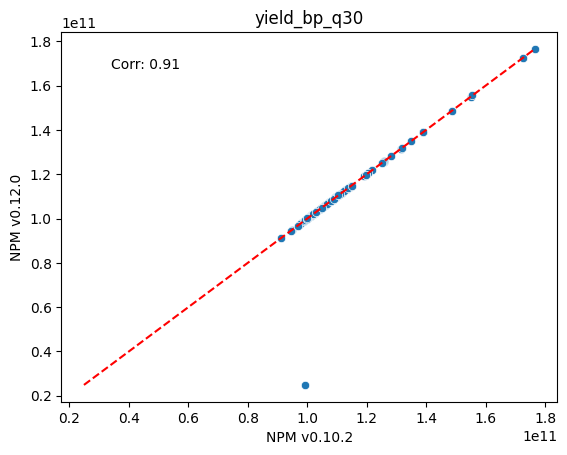

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load data
df_A = load_metrics(A_dir)
df_B = load_metrics(B_dir)

# For each metric
for col in df_A.columns[1:]:
    # Create a scatter plot
    sns.scatterplot(data=df_A, x=col, y=df_B[col])

    # Calculate correlation coefficient
    corr = df_A[col].corr(df_B[col])
    plt.text(0.1, 0.9, f'Corr: {corr:.2f}', transform=plt.gca().transAxes)

    # Add diagonale line
    gmin = min(df_A[col].min(), df_B[col].min())
    gmax = max(df_A[col].max(), df_B[col].max())
    plt.plot([gmin, gmax], [gmin, gmax], color='red', linestyle='--')
    
    # Set plot title and labels
    plt.title(f'{col}')
    plt.xlabel(f'{A_label}')
    plt.ylabel(f'{B_label}')
    
    # Show the plot
    plt.show()